In [2]:
import numpy as np
from math import exp, sqrt
import matplotlib.pyplot as plt
from BayesODE import var_car, cov_car

Create a function

def car_cov(tseq, roots, corr = False)
which computes N x p x p tensor of $\operatorname{cov}(X_0, X_t)$ for each $t$ in tseq. Note that this quantity only exists when $X_t$ is stationary, which should be when $r_k > 0$ or $-r_k > 0$, depending on how we've parametrized things.

With this function, please plot $\gamma_k(t) = \operatorname{cor}(Z_0^{(k)}, X_t^{(k)})$ as a function of $t$. The goal is to relate the $r_k$ to the decorrelation time $\tau_k$ given by $\gamma_k(\tau_k) = 1/e$. So for example, if we have $r_k = \exp{r_0 k}$, please plot $\tau_k$ as a function of $r_0$. If we can control the $\tau_k$ this way, then we have a very simple way of parametrizing the CAR(p) process (for our purposes).

Create plots of $\operatorname{var}(Z_t^{(k)})$ vs $t$ for each $k = 0, \ldots, p-1$.

In [20]:
def rootgen(r0, n):
    roots = np.zeros(n)
    r = r0
    for k in range(n):
        roots[k] = -r
        r = exp(r0*(k+1))
    return roots

In [24]:
r0 = 1
roots = rootgen(r0, 3) #All roots need to be negative
tseq = np.linspace(0,1,10)
V = var_car(tseq, roots)

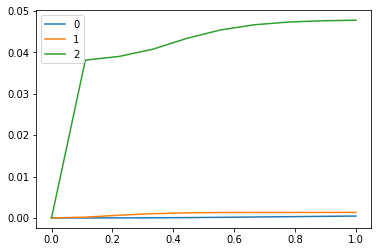

In [25]:
for k in range(len(roots)):
    plt.plot(tseq, V[:,k,k], label=k)
plt.legend(loc='upper left')
plt.show()

In [27]:
cov =cov_car(tseq, roots)

In [137]:
def getgamma(cov):
    gamma = np.zeros(cov.shape)
    for t in range(cov.shape[0]):
        D = np.diag(np.diag(cov[t]))
        D_half = np.sqrt(D)
        gamma[t] = np.linalg.multi_dot([np.linalg.pinv(D_half), cov[t], D_half])
    return gamma

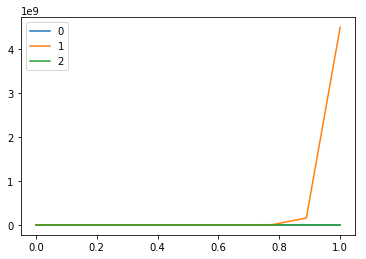

In [138]:
gamma = getgamma(cov)
for k in range(len(roots)):
    plt.plot(tseq, gamma[:,k,k], label=k)
plt.legend(loc='upper left')
plt.show()
#plt.plot(tseq,gamma)

In [149]:
def decorrelation(roots, k, tol=1e-5):
    t = 0.1
    
    while True:
        cov = cov_car(np.array([t]), roots)
        gamma_k = getgamma(cov)[0][k,k]
        if abs(gamma_k-1/exp(1)) < tol:
            return t
        elif gamma_k>1/exp(1):
            t = t - t/100
        else:
            t = t + t/100

In [150]:
decorrelation(roots, 2)

0.5559638620506795

# Unit Test

In [58]:
r0 = 1
roots = rootgen(r0, 3)

delta = -roots
D = np.diag(delta)
p = len(roots)
Q = np.zeros((p, p))

row = np.ones(p)
for i in range(p):
    Q[i] = row
    row = row*roots

Q_inv = np.linalg.pinv(Q)
Gamma = np.linalg.multi_dot([Q, D, Q_inv])

In [76]:
from sympy import symbols, expand, Poly
s = symbols('s')
product = 1
for root in roots:
    product = product * (s - root)
coeffs = Poly(expand(product)).coeffs()
np.allclose(np.array(coeffs[:0:-1], dtype='float'),Gamma[-1])

True

In [77]:
def V_euler_N1(Sigma, Delta_t):
    return Sigma*Delta_t

In [183]:
def var_car_test(Q, D, Sigma, Delta_t):
    
    delta = np.diag(D)
    Q_inv = np.linalg.pinv(Q)
    Gamma = np.linalg.multi_dot([Q, D, Q_inv]) #Q*D*Q^-1
    Sigma_tilde = np.linalg.multi_dot([Q_inv, Sigma, Q_inv.T]) #Q^-1*Sigma*Q^-1'

    V_tilde = np.zeros((p,p))
    for i in range(p):
        for j in range(i, p):
            V_tilde[i,j] = Sigma_tilde[i,j] / (delta[i] + delta[j]) * (1- exp(- (delta[i] + delta[j]) * Delta_t)) #V_tilde
            V_tilde[j,i] = V_tilde[i,j]

    V = np.linalg.multi_dot([Q, V_tilde, Q.T]) #V_deltat
    return V

In [212]:
V_euler_N1(Sigma, Delta_T[t])

array([[  9.86941764e-18,   7.78025838e-17,   2.77627860e-17],
       [  6.69444227e-17,   7.38944939e-17,   9.95817597e-17],
       [  4.01029770e-17,   2.74869160e-17,   6.25489121e-17]])

In [ ]:
var_car_test(Q)

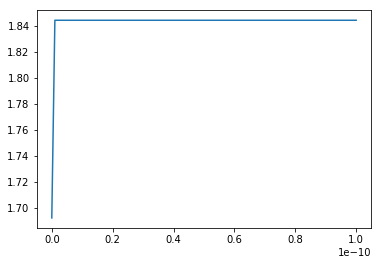

In [210]:
Delta_T = np.linspace(1e-1, 1e-16, 100)
Q = np.ones((3,3))
D = np.diag([1,2,3])
Sigma = np.random.rand(3,3)

compare = np.zeros(len(Delta_T))
for t in range(len(Delta_T)):
    compare[t] = np.max(V_euler_N1(Sigma, Delta_T[t])/var_car_test(Q, D, Sigma, Delta_T[t]))
    
plt.plot(Delta_T, compare)

In [78]:
Sigma_half = np.zeros((p,p))
Sigma_half[p-1,p-1] = sigma
Sigma = Sigma_half.dot(Sigma_half)

Sigma_tilde = np.linalg.multi_dot([Q_inv, Sigma, Q_inv.T])

In [ ]:
V

In [79]:
Delta_t = 0.0000001
V_euler_N1(Sigma, Delta_t)/var_car(np.array([Delta_t]), roots)[0]

array([[ 0.        , -0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.00000111]])

In [46]:
t = 1
V_tilde = np.zeros((p,p))

for i in range(p):
    for j in range(i, p):
        V_tilde[i,j] = Sigma_tilde[i,j] / (delta[i] + delta[j]) * (1- exp(- (delta[i] + delta[j]) * t))
        V_tilde[j,i] = V_tilde[i,j]
V = np.linalg.multi_dot([Q, V_tilde, Q_inv])

In [ ]:
Gamma

In [ ]:
B = 1000
N = 100
X0 = np.zeros(p)
out = np.zeros((B,p))
delta_t = t/N

In [ ]:
for b in range(B):
    X = X0
    for t in range(1,N+1):
        deltaB_n = np.random.multivariate_normal(X0, np.identity(p)*delta_t)
        X = X + Gamma.dot(X)*delta_t + Sigma_half.dot(deltaB_n)
    out[b] = X

In [ ]:
a = [o[0] for o in out]
b = [o[1] for o in out]
np.var(a)
np.var(b)

In [ ]:
np.cov(b,b)

In [ ]:
np.var(out, axis=0)

In [ ]:
deltaB_n = np.random.multivariate_normal(X0, np.identity(p)*delta_t)
deltaB_n